In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import time
matfile = sio.loadmat('data_mac1.mat')
data = matfile['data']

print(data.dtype.names)
print(data.shape)
# format: data['variable name'] [0] [sample index] [0] [time step]
# e.g.: print(data['bus_v']     [0]     [432]      [0]   [124])

('bus_v', 'cur', 'bus_freq', 'mac_ang', 'mac_spd', 'pelect', 'pmech', 'qelect', 'length')
(1, 5864)


In [2]:
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name, end='')
        print('Elapsed: %.2fs' % (time.time() - self.tstart))

In [3]:
# Data pre-processing
np.random.seed(20200412)
n_sample = 1500
sample_idx = np.random.permutation(5864)
# sample_idx = np.arange(5864)

# Train data set size: (4379554, 18)
# Test data set size: (759128, 18)

train_data = np.zeros((1313141, 18), dtype=np.float32)
train_label_raw = np.zeros((1313141, 8), dtype=np.float32)
# train_data = np.zeros((9000000, 18), dtype=np.float32)
# train_label = np.zeros((9000000, 18), dtype=np.float32)
n_entry = 0
with Timer('Import train data'):
    for i in sample_idx[:n_sample]:
        bus_v = data['bus_v'][0][i].reshape(-1, 1)
        cur = data['cur'][0][i].reshape(5, -1).T
        bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
        mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
        mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
        pelect = data['pelect'][0][i].reshape(-1, 1)
        pmech = data['pmech'][0][i].reshape(-1, 1)
        qelect = data['qelect'][0][i].reshape(-1, 1)

        tmp_train_data = np.hstack([np.real(bus_v), np.imag(bus_v), np.real(cur), np.imag(cur), bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
        tmp_train_label = np.delete(tmp_train_data, 0, 0)  # delete the first sample(shift the curve left)
        tmp_train_label = np.delete(tmp_train_label, np.arange(2, 12), 1)  # delete the last sample because there's no corresponding label
        tmp_train_data = np.delete(tmp_train_data, -1, 0)  # delete the current(we don't need to predict that)

        length = tmp_train_data.shape[0]
        train_data[n_entry:n_entry + length, :] = tmp_train_data
        train_label_raw[n_entry:n_entry + length, :] = tmp_train_label
        n_entry += length
    del tmp_train_data
    del tmp_train_label

#     train_data = train_data[:n_entry, :].copy()
#     train_label = train_label[:n_entry, :].copy()

test_data = np.zeros((757097, 18), dtype=np.float32)
test_label_raw = np.zeros((757097, 8), dtype=np.float32)
# test_data = np.zeros((9000000, 18), dtype=np.float32)
# test_label = np.zeros((9000000, 18), dtype=np.float32)

n_entry = 0
with Timer('Import test data'):
    for i in sample_idx[5000:]:
        bus_v = data['bus_v'][0][i].reshape(-1, 1)
        cur = data['cur'][0][i].reshape(5, -1).T
        bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
        mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
        mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
        pelect = data['pelect'][0][i].reshape(-1, 1)
        pmech = data['pmech'][0][i].reshape(-1, 1)
        qelect = data['qelect'][0][i].reshape(-1, 1)

        tmp_test_data = np.hstack([np.real(bus_v), np.imag(bus_v), np.real(cur), np.imag(cur), bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
        tmp_test_label = np.delete(tmp_test_data, 0, 0)  # delete the first sample(shift the curve left)
        tmp_test_label = np.delete(tmp_test_label, np.arange(2, 12), 1)  # delete the last sample because there's no corresponding label
        tmp_test_data = np.delete(tmp_test_data, -1, 0)
        length = tmp_test_data.shape[0]
        test_data[n_entry:n_entry + length, :] = tmp_test_data
        test_label_raw[n_entry:n_entry + length, :] = tmp_test_label
        n_entry += length
    del tmp_test_data
    del tmp_test_label

#     test_data = test_data[:n_entry, :].copy()
#     test_label = test_label[:n_entry, :].copy()


train_label = train_label_raw - train_data[:, [0, 1, 12, 13, 14, 15, 16, 17]]
test_label = test_label_raw - test_data[:, [0, 1, 12, 13, 14, 15, 16, 17]]

label_mean = np.mean(train_label, axis=0)
label_std = np.std(train_label, axis=0)
label_std[np.less(label_std, 1e-7)] = 1e-7
train_label = (train_label - label_mean) / label_std
test_label = (test_label - label_mean) / label_std

norm_mean = np.mean(train_data, axis=0)
norm_std = np.std(train_data, axis=0)
norm_std[np.less(norm_std, 1e-7)] = 1e-7
train_data = (train_data - norm_mean) / norm_std
test_data = (test_data - norm_mean) / norm_std

print('Train data set size:', train_data.shape)
print('Test data set size:', test_data.shape)

[Import train data]Elapsed: 0.31s
[Import test data]Elapsed: 0.18s
Train data set size: (1313141, 18)
Test data set size: (757097, 18)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        feature_dimension = 128

        self.network = nn.Sequential(
            nn.Linear(18, feature_dimension),
#             nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.ReLU(inplace=True),
#             nn.BatchNorm1d(feature_dimension),

            nn.Linear(feature_dimension, feature_dimension),
            nn.ReLU(inplace=True),
#             nn.BatchNorm1d(feature_dimension),

            nn.Linear(feature_dimension, 8)
            )

    def forward(self, x):
        x = self.network(x)
        return x


def weights_init(m):
    if isinstance(m, nn.Linear):
        #         torch.nn.init.kaiming_normal_(m.weight)
#         torch.nn.init.normal_(m.weight, mean=0, std=0.001)
        torch.nn.init.normal_(m.bias, mean=0, std=0.001)
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
#         nn.init.kaiming_uniform_(m.bias, mode='fan_in', nonlinearity='relu')

    if isinstance(m, nn.BatchNorm1d):
        torch.nn.init.zeros_(m.bias)
        torch.nn.init.ones_(m.weight)

Before training: train Loss = 3.583e+00, test Loss = 3.354e+00
10:59:40  Epoch 50: train Loss = 6.868e-02, test Loss = 5.808e-02
10:59:51  Epoch 100: train Loss = 5.500e-02, test Loss = 4.908e-02
11:00:03  Epoch 150: train Loss = 4.387e-02, test Loss = 4.195e-02
11:00:14  Epoch 200: train Loss = 3.820e-02, test Loss = 3.882e-02
11:00:26  Epoch 250: train Loss = 3.436e-02, test Loss = 3.687e-02
11:00:37  Epoch 300: train Loss = 3.144e-02, test Loss = 3.534e-02
11:00:48  Epoch 350: train Loss = 3.005e-02, test Loss = 3.489e-02
11:01:00  Epoch 400: train Loss = 2.809e-02, test Loss = 3.379e-02
11:01:11  Epoch 450: train Loss = 2.674e-02, test Loss = 3.328e-02
11:01:23  Epoch 500: train Loss = 2.555e-02, test Loss = 3.275e-02
11:01:34  Epoch 550: train Loss = 2.482e-02, test Loss = 3.271e-02
11:01:45  Epoch 600: train Loss = 2.400e-02, test Loss = 3.268e-02
11:01:57  Epoch 650: train Loss = 2.358e-02, test Loss = 3.291e-02
11:02:08  Epoch 700: train Loss = 2.286e-02, test Loss = 3.291e-02


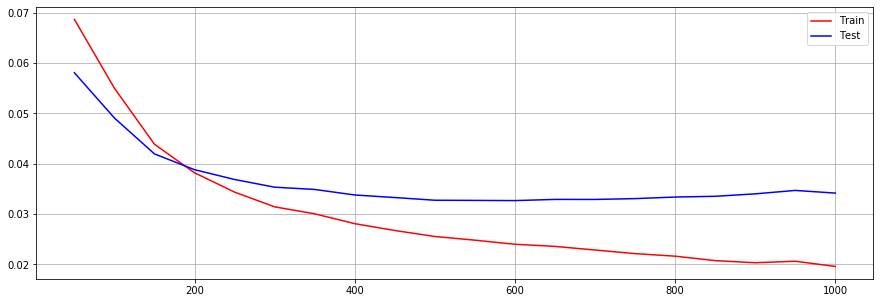

GPU memory stats: Max Cached 130 Mb, Max Reserved 130 Mb, Max Allocated 114 Mb
Final: train Loss = 6.162e-05, test Loss = 8.128e-05
mac_spd: train Loss = 7.359e-11, test Loss = 7.701e-11


In [5]:
%matplotlib inline

model = NN().float()
use_GPU = False
torch.manual_seed(20200410)

if torch.cuda.is_available():
    use_GPU = True
    model = model.cuda()

    torch.cuda.empty_cache()
    torch.cuda.manual_seed(20200410)
    torch.cuda.manual_seed_all(20200410)
    torch.backends.cudnn.deterministic = True

model.apply(weights_init)

batchsize = 50000
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01*2, momentum=0.9, nesterov=True)
# optimizer = optim.Adam(model.parameters())

train_data_torch = torch.from_numpy(train_data).float()
train_label_torch = torch.from_numpy(train_label).float()
test_data_torch = torch.from_numpy(test_data).float()
test_label_torch = torch.from_numpy(test_label).float()

loss_curve = []

# f0 = plt.figure(0, figsize=(15,5))
# ax0 = f0.gca()
# ax0.plot([0])
# f0.canvas.draw()


def test(data_torch, label_torch):
    batchsize = 50000
    loss = None
    prediction = None

    model.eval()
    for j in range(0, data_torch.shape[0], batchsize):
        inputs_torch = data_torch[j:j+batchsize, :]
        labels_torch = label_torch[j:j+batchsize, :]

        if use_GPU:
            inputs_torch = inputs_torch.cuda()
            labels_torch = labels_torch.cuda()

        # forward
        pred_torch = model(inputs_torch)
        loss_torch = criterion(pred_torch, labels_torch)

        if use_GPU:
            pred_torch = pred_torch.cpu()
        pred = pred_torch.data.numpy()

        loss = np.array([loss_torch.item()]) if loss is None else np.hstack([loss, loss_torch.item()])
        prediction = pred if prediction is None else np.vstack([prediction, pred])
    return loss.mean(), prediction


loss, _ = test(train_data_torch, train_label_torch)
loss_test, _ = test(test_data_torch, test_label_torch)
print('Before training: train Loss = %.3e, test Loss = %.3e' % (loss, loss_test))

for i in range(1, 1001):
    model.train()
    for j in range(0, train_data.shape[0], batchsize):
        inputs = train_data_torch[j:j+batchsize, :].cuda()
        labels = train_label_torch[j:j+batchsize, :].cuda()
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i % 50 == 0:
        loss, _ = test(train_data_torch, train_label_torch)
        loss_test, _ = test(test_data_torch, test_label_torch)

        loss_curve.append([i, loss, loss_test])

    if i % 50 == 0:
        print(time.strftime('%H:%M:%S  ', time.localtime(time.time())), end="")
        print('Epoch {}: train Loss = {:.3e}, test Loss = {:.3e}'.format(i, loss, loss_test))

#         ax0.cla()
#         ax0.plot(np.array(loss_curve)[:,0], np.array(loss_curve)[:,1], 'r', label="Train")
#         ax0.plot(np.array(loss_curve)[:,0], np.array(loss_curve)[:,2], 'b', label="Test")
#         ax0.legend()
#         ax0.grid(True)
#         f0.canvas.draw()

plt.figure(0, figsize=(15, 5))
plt.plot(np.array(loss_curve)[:, 0], np.array(loss_curve)[:, 1], 'r', label="Train")
plt.plot(np.array(loss_curve)[:, 0], np.array(loss_curve)[:, 2], 'b', label="Test")
plt.grid(True)
plt.legend()
plt.show()


# plt.ylim([0,np.array(loss_curve)[-1,2]*10])

print('GPU memory stats: Max Cached {:.0f} Mb, Max Reserved {:.0f} Mb, Max Allocated {:.0f} Mb'.format(
    torch.cuda.max_memory_cached(0)/1024/1024, torch.cuda.max_memory_reserved(0)/1024/1024, torch.cuda.max_memory_allocated(0)/1024/1024))


_, prediction_train = test(train_data_torch, train_label_torch)
_, prediction_test = test(test_data_torch, test_label_torch)

prediction_train = prediction_train * label_std + label_mean + (train_data * norm_std + norm_mean)[:, [0, 1, 12, 13, 14, 15, 16, 17]]
prediction_test = prediction_test * label_std + label_mean + (test_data * norm_std + norm_mean)[:, [0, 1, 12, 13, 14, 15, 16, 17]]

mse_train = np.mean(np.square(prediction_train - train_label_raw), axis=0)
mse_test = np.mean(np.square(prediction_test - test_label_raw), axis=0)

print('Final: train Loss = %.3e, test Loss = %.3e' % (mse_train.mean(), mse_test.mean()))
print('mac_spd: train Loss = %.3e, test Loss = %.3e' % (mse_train[4], mse_test[4]))

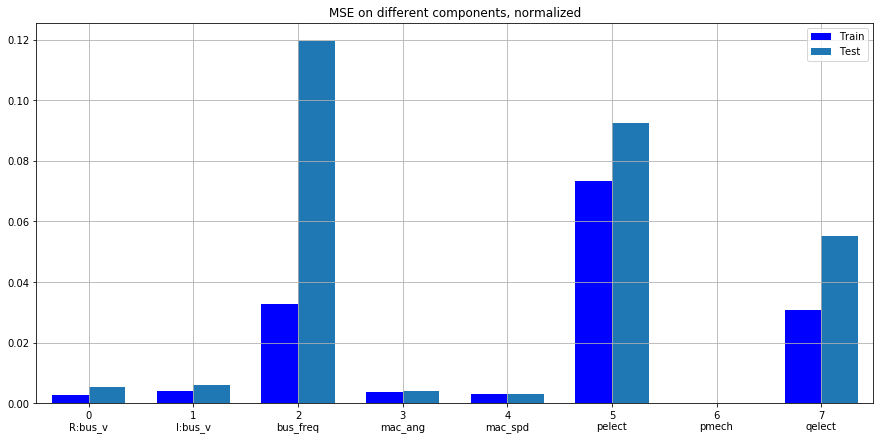

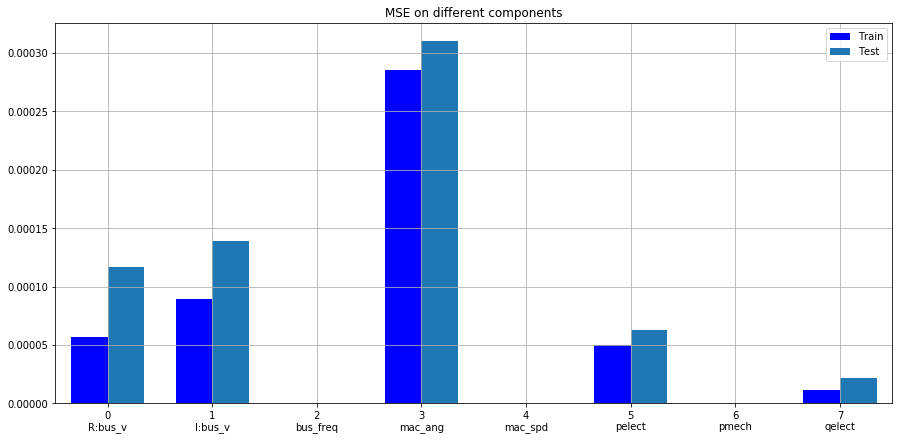

In [6]:
c = ['b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'orange', 'b', 'b', 'b']
c2 = ['C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'C0', 'darkorange', 'C0', 'C0', 'C0']
x = np.arange(8)
# xticks=('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect')
xticks = ('0\nR:bus_v', '1\nI:bus_v', '2\nbus_freq', '3\nmac_ang', '4\nmac_spd', '5\npelect', '6\npmech', '7\nqelect')
width = 0.35

# plt.figure(1,figsize=(15,7))
# plt.bar(range(8), norm_std, color=c)
# plt.xticks(range(8), ('0\nR:bus_v', '1\nI:bus_v', '2\nR:cur1', '3\nR:cur2', '4\nR:cur3', '5\nR:cur4', '6\nR:cur5', '7\nI:cur1', '8\nI:cur2', '9\nI:cur3', \
#                        '10\nI:cur4', '11\nI:cur5', '12\nbus_freq', '13\nmac_ang', '14\nmac_spd', '15\npelect', '16\npmech', '17\nqelect'))
# plt.grid(True)
# plt.xlim([-0.5,17.5])
# # plt.ylim([0,0.001])
# plt.title('Standard Deviations on different components')

plt.figure(2, figsize=(15, 7))
plt.bar(x-width/2, mse_train/label_std/label_std, width, label='Train', color=c)
plt.bar(x+width/2, mse_test/label_std/label_std, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
# plt.ylim([0,1e-6])
plt.title('MSE on different components, normalized')


plt.figure(3, figsize=(15, 7))
plt.bar(x-width/2, mse_train, width, label='Train', color=c)
plt.bar(x+width/2, mse_test, width, label='Test', color=c2)
plt.xticks(x, xticks)
plt.grid(True)
plt.xlim([-0.5, 7.5])
plt.legend()
# plt.ylim([0,1e-1])
plt.title('MSE on different components')

plt.show()

(800, 8)
(800, 8)


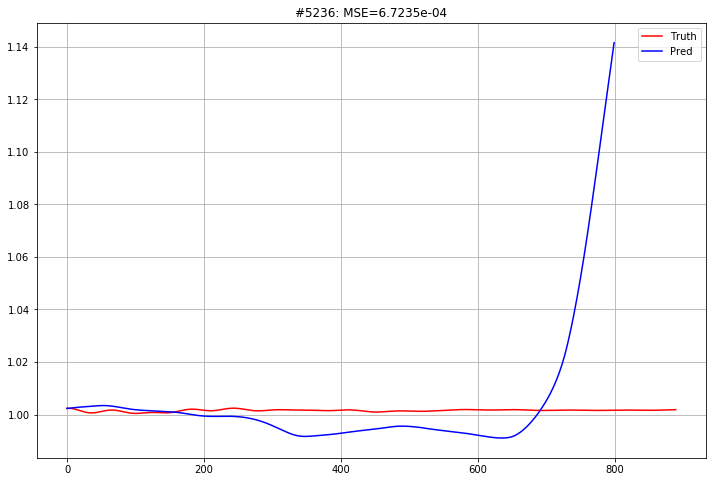

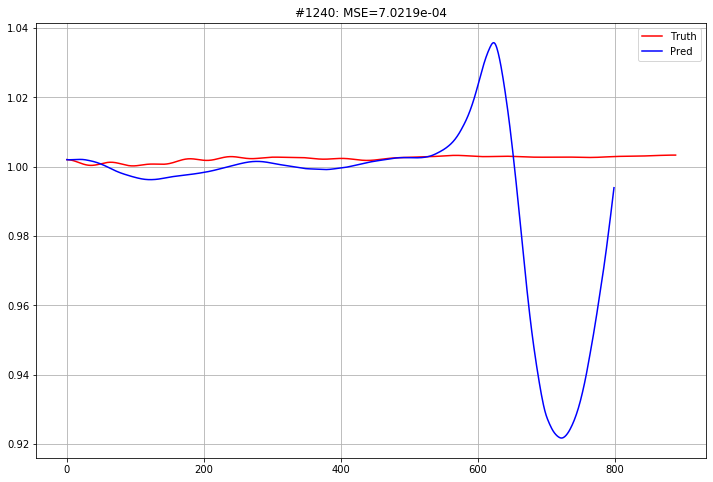

In [8]:
entry = np.floor(np.random.uniform(low=0, high=5864, size=(2, 1))).astype(int).reshape(-1)
# entry=[sample_idx[1], sample_idx[5]]
t_max = 800

model_cpu = model.cpu()
model_cpu.eval()
for i in entry:
    bus_v = data['bus_v'][0][i].reshape(-1, 1)
    cur = data['cur'][0][i].reshape(5, -1).T
    bus_freq = data['bus_freq'][0][i].reshape(-1, 1)
    mac_ang = data['mac_ang'][0][i].reshape(-1, 1)
    mac_spd = data['mac_spd'][0][i].reshape(-1, 1)
    pelect = data['pelect'][0][i].reshape(-1, 1)
    pmech = data['pmech'][0][i].reshape(-1, 1)
    qelect = data['qelect'][0][i].reshape(-1, 1)

    tmp_test_data = np.hstack([np.real(bus_v), np.imag(bus_v), np.real(cur), np.imag(cur), bus_freq, mac_ang, mac_spd, pelect, pmech, qelect])
    tmp_test_data = (tmp_test_data - norm_mean) / norm_std

#     tmp_test_label = np.delete(tmp_test_data, 0, 0)
    tmp_test_data = np.delete(tmp_test_data, -1, 0)

#     tmp_test_data[:,13] = 0

#     input_data_torch = torch.from_numpy(tmp_test_data).float()
#     prediction = model_cpu(input_data_torch).data.numpy()
#     prediction = prediction * label_std + label_mean + tmp_test_data * norm_std + norm_mean
#     print(prediction.shape)
#     mac_spd = mac_spd[1:]

#     plt.figure(figsize = (12,8))
#     plt.plot(mac_spd,'r')
#     plt.plot(prediction[:,14], 'b')
#     plt.legend(['Truth','Pred'])
#     plt.grid(True)
#     plt.title('#%d: MSE=%.4e benchmark=%.4e'%(i, np.mean(np.square(prediction[:,14] - mac_spd)), np.mean(np.square(tmp_test_data[:,14]*norm_std[14]+norm_mean[14] - mac_spd))))

    prediction2 = np.zeros((t_max, 8))
    input_data = tmp_test_data[[0], :]
    for t in range(t_max):
        input_data_torch = torch.from_numpy(input_data).float()
        output_data_torch = model_cpu(input_data_torch)
        prediction2[t] = output_data_torch.data.numpy() * label_std + label_mean + (input_data * norm_std +
                                                                                    norm_mean)[:, [0, 1, 12, 13, 14, 15, 16, 17]]

        input_data = np.concatenate([prediction2[t, [0, 1]], tmp_test_data[t, [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], prediction2[t, [2, 3, 4, 5, 6, 7]]])
        input_data = (input_data - norm_mean) / norm_std
        input_data = input_data.reshape(1, -1)
    print(prediction2.shape)

    plt.figure(figsize=(12, 8))
    plt.plot(mac_spd, 'r')
    plt.plot(prediction2[:, 4], 'b')
    plt.legend(['Truth', 'Pred'])
    plt.grid(True)
#     plt.ylim([0.97, 1.03])
    plt.title('#%d: MSE=%.4e' % (i, np.mean(np.square(prediction2[:, 4] - mac_spd[:t_max].reshape(-1)))))

plt.show()